 # <font color="#114b98">      <div align="center">  Anticipez les besoins en consommation de bâtiments </font>    

Le premier notebook contient le jeu de données de la consommation de l'énergie 
sous le nom "Cleaned_energie_co2.csv". Nous l'exportons ici (dans ce présent Notebook) afin de réaliser une 
comparaison de diverses modèles linéaires et non-linéaires. Ensuite choisier le meilleur modèle pour prédier 
les émissions de CO2 et les consommations d'énergie des bâtiments. 


## <font color="#ea1c60">Sommaire</font>  
[1. Pipelines et préparation des données](#section_1)

[2. Comparaison des modèles pour les emissions du Co_2](#section_2) 

[2.1 Modèles de régression linéaires](#section_21) 

[2.2 Modèles de régression non-linéaires](#section_22)

[2.3 Comparaison des résultats](#section_23)

[2.4 Cross validation pour RFR et GBR](#section_24)

[3. Comparaison des modèles pour l'énergie totale](#section_3)

[3.1 Modèles de régression linéaires](#section_31) 

[3.2 Modèles de régression non-linéaires](#section_32)

[3.3 Comparaison des résultats](#section_33)

[3.4 Cross validation pour RFR et GBR](#section_34)

[4. Feature importances](#section_4) 

[5. Prédictions des modèles séléctionés](#section_5)

[6. Influence de l'ENERGY STAR Score](#section_6)

## <font id="section_1"> 1. Pipelines et préparation des données

Chargement du jeu de données:

In [4]:
import pandas as pd
data_unif = pd.read_csv('Cleaned_energie_co2.csv', sep='\t',low_memory=False)

On vérifie si nous avons bien exporté le dataset:

In [7]:
data_unif.shape

(3284, 16)

In [6]:
data_unif.head()

,BuildingType,PrimaryPropertyType,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),Latitude,Longitude
0,NonResidential,Hotel,88,1.0,12.0,0,Hotel,88434.0,Hotel,0.0,0.0,65.0,6981428.0,249.43,47.612190,-122.337997
1,NonResidential,Hotel,19,1.0,11.0,15064,Hotel,83880.0,Parking,15064.0,4622.0,51.0,8354235.0,263.51,47.613106,-122.333358
2,NonResidential,Hotel,46,1.0,41.0,0,Hotel,757243.0,Parking,100000.0,0.0,18.0,73130656.0,2061.48,47.613349,-122.337699
3,NonResidential,Hotel,89,1.0,10.0,0,Hotel,61320.0,Hotel,0.0,0.0,1.0,28229320.0,1936.34,47.614216,-122.336609
4,NonResidential,Hotel,35,1.0,18.0,12460,Hotel,123445.0,Parking,68009.0,0.0,67.0,14829099.0,507.70,47.613754,-122.340924


Chargement des librairies:

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display="diagram")

Variables explicatives et variables expliquées

In [4]:
y = data_unif[['GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)']]
X = data_unif[data_unif.columns.drop(['GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)'])]

Nous allons spliter nos données pour obtenir un jeu d'entrainement et un jeu de test (25% des données):

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

Dans cette partie, nous définissons les métriques utilisées, la MAE et la RMSE et le coefficient de détermination $R_2$.
La RMSE est plus sensible que la MAE aux valeurs qui s'écartent de la normale:

$$\mbox{RMSE} =\sqrt{\frac{\sum_{i=1}^n (\hat{y}_i-y_i)^2}{n}}$$

$$\mbox{MAE} =\frac{\sum_{i=1}^n |\hat{y}_i-y_i|}{n}$$

$$R_2 = 1-\frac{RMSE^2}{var[y]}$$


In [6]:
def model_accuracy(y_pred,y_test):
    SSR = ((y_pred-y_test)**2).mean()
    SST = (((y_test-y_test.mean())**2).mean())
    r2 = 1-SSR/SST
    print("MAE (L1)       %.4f" %    abs(y_pred-y_test).mean())
    print("RMSE (L2)      %.4f" %    np.sqrt(((y_pred-y_test)**2).mean()))
    print("Mediane-AE      %.4f" %   (abs(y_pred-y_test)).median())
    print("R2 (CV)          %.4f"%  r2)

Avant d'utiliser notre jeu de données pour des régressions, nous allons effectuer un prétraitement concernant une transformation des varaibles catégorielles et numériques. L'encodeur *OneHotEncoder* sera utilisé pour encoder les colonnes de catégories, et une normalisation des colonnes numériques à travers *MinMaxScaler*. Ce dernier transformeur, nous a permis d'éviter des divergences pour certains  fits pour le modèle SVR.



In [7]:
from sklearn.compose import ColumnTransformer
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_transf = OneHotEncoder(handle_unknown="ignore")
num_transf = MinMaxScaler()
C_transf =ColumnTransformer(
    transformers =[('cat',cat_transf, cat_selector), ('num',num_transf, num_selector)])
C_transf

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CDEA8F5970>),
                                ('num', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CDEA8F5E80>)])

In [8]:
C_transf.fit(X).transformers_

[('cat',
  OneHotEncoder(handle_unknown='ignore'),
  ['BuildingType',
   'PrimaryPropertyType',
   'LargestPropertyUseType',
   'SecondLargestPropertyUseType']),
 ('num',
  MinMaxScaler(),
  ['Agebuilding',
   'NumberofBuildings',
   'NumberofFloors',
   'PropertyGFAParking',
   'LargestPropertyUseTypeGFA',
   'SecondLargestPropertyUseTypeGFA',
   'ThirdLargestPropertyUseTypeGFA',
   'ENERGYSTARScore',
   'Latitude',
   'Longitude'])]

Nous avons vu qu'une transformation logarithmique des variables cibles permet  d'obtenons une distribution gaussienne des données à prédire.
Nous allons donc appliquer cette transformation $\log(1+x) $ dans notre pipeline grâce à l'objet **TransformedTargetRegressor** de la librairie Sklearn, où la fonction inverse $e^x-1$ est appliquée sur les prédictions.

In [9]:
def estimator_pipeline(clf, C_transform):
   model_pipe = Pipeline(steps=[('ct', C_transform),('regressor', clf)])
   clf_t = TransformedTargetRegressor(regressor=model_pipe,
                                     func=np.log1p, 
                                     inverse_func=np.expm1)
   return clf_t 

## <font id="section_2"> 2. Comparaison des modèles pour les emissions du $Co_2$

Nous allons commencer par prédire notre variable cible avec le modèle 
dummy:

In [10]:
dummy_t = estimator_pipeline(DummyRegressor(strategy="mean"), C_transf)
dummy_t

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('ct',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001CDEA8F5970>),
                                                                                      ('num',
                                                                                       MinMaxScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001CDEA8F5E80>)])),
                                                     ('regressor',
                                                      DummyRegressor())]))

In [ ]:
import time
start_time = time.time()
dummy_t.fit(X_train,y_train['GHGEmissions(MetricTonsCO2e)'])
t=time.time() - start_time
model_accuracy(dummy_t.predict(X_test),y_test['GHGEmissions(MetricTonsCO2e)'])

MAE (L1)       139.7708
RMSE (L2)      570.4369
Mediane-AE      40.0125
R2 (CV)          -0.0362


Tous les résultats des scores seront stockés dans la suite dans la DataFrame clf_sc pour la  variable "*GHGEmissions(MetricTonsCO2e)*".

In [ ]:
index=['R2', 'RMSE','MFT_total(s)','MFT(s)']
clc_sc =pd.DataFrame({'Dummy':np.array([-0.0362, -570.437, '-', round(t,3)])},index=index)

In [11]:
clf_lm = estimator_pipeline(LinearRegression(), C_transf)
clf_lm

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('ct',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001CDEA8F5970>),
                                                                                      ('num',
                                                                                       MinMaxScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001CDEA8F5E80>)])),
                                                     ('regressor',
                                                      LinearRegression())]))

In [ ]:
clf_lm_t = estimator_pipeline(LinearRegression(), C_transf)
clf_lm_t.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
model_accuracy(clf_lm_t.predict(X_test),y_test['GHGEmissions(MetricTonsCO2e)'])

MAE (L1)       380.4935
RMSE (L2)      5155.6232
Mediane-AE      25.8594
R2 (CV)          -83.6461


Nous allons comparer des modèles de régression linéaires et non-linéaires avec des paramètres optimisés. 
Nous utilisons la fonction GridsearchCV pour générer une grille des estimateurs pour chaque modèle.
deux métriques sont choisies pour cette comparaison, le 'R$_2$' et 'neg_root_mean_squared_error'. Les modèles linéares considérés sont:
- Le régresseur linéaire classqiue
- Le régresseur linéaire régularisé Ridge,  Lasso et ElasticNet
les  modèles non-linéares sont onsidérés:
- Le régresseur Support Vector (SVR) à noyau non-linéaire
- Le random forest régresseur (RFR)
- Le Gradient Boosting régresseur (GBR)


In [ ]:
metric = ['r2','neg_root_mean_squared_error']

### <font id="section_21"> 2.1 Modèles de régression linéaires
#### <font id="section_211"> 2.1.1 Régression linéaire classique

In [ ]:
Sc=[]
param_grid ={'regressor__regressor__fit_intercept':[False,True]}
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_lm_t, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(round(grid_result.best_score_,2))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'MLR':Sc},index=index)],axis=1)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
r2 : -845.5087486635224
Best Params:  {'regressor__regressor__fit_intercept': True}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
neg_root_mean_squared_error : -7729.421695402829
Best Params:  {'regressor__regressor__fit_intercept': False}
mean_fit_time: 2.2341551780700684


On remarque que le modèle de régression linéaire multivarié classique affiche des mauvaises scores sur la grille.
Ceci peut être expliquer par la sensibilité de ce modèle classqiue aux problèmes d'hétéroscédasticié.

#### <font id="section_212"> 2.1.2 Régularisation Ridge

Ridge régression impose une pénalité sur l'amplitude des coefficients. Ridge coefficients $w$ minimisent une somme résiduelle des carrés pénalisée :
$$
\min_{w}\|Xw-\log(1+y)\|_2^2+\alpha\sum_{j=0}^{n_s}w_j^2,
$$
where the paramètre de complexité $\alpha>0$ contrôle la quantité de rétrécissement.

In [ ]:
Sc=[]
clf_ridge = estimator_pipeline(Ridge(), C_transf)
param_grid = {'regressor__regressor__alpha':np.linspace(0.001,40,41),
              'regressor__regressor__tol':[0.5,0.1,0.01]}
for sc in metric:              
  grid_search = GridSearchCV(estimator = clf_ridge, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'Ridge':Sc},index=index)],axis=1)

Fitting 10 folds for each of 123 candidates, totalling 1230 fits
r2 : 0.4891889274305582
Best Params:  {'regressor__regressor__alpha': 11.000725000000001, 'regressor__regressor__tol': 0.1}
Fitting 10 folds for each of 123 candidates, totalling 1230 fits
neg_root_mean_squared_error : -344.8340945706204
Best Params:  {'regressor__regressor__alpha': 9.000774999999999, 'regressor__regressor__tol': 0.1}
mean_fit_time: 42.63601422309876


La régularisation Ridge améliore nettement les scores des prédictions sur la grille GridSearchCV.

#### <font id="section_213"> 2.1.3 Régularisation Lasso

Lasso régression  impose une pénalité sur l'amplitude des coefficients. Ridge coefficients $w$ minimisent une somme résiduelle des carrés pénalisée :
$$
\min_{w}\|Xw-\log(1+y)\|_2^2+\alpha\sum_{j=0}^{n_s}|w_j|,
$$


In [ ]:
Sc=[]
clf_lasso = estimator_pipeline(Lasso(), C_transf)
param_grid = {'regressor__regressor__alpha':np.linspace(0.001,40,81),
              'regressor__regressor__tol':[0.1,0.05,0.001]}
for sc in metric:              
  grid_search = GridSearchCV(estimator = clf_lasso, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'Lasso':Sc},index=index)],axis=1)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
r2 : -0.06071257064347777
Best Params:  {'regressor__regressor__alpha': 0.5009875, 'regressor__regressor__tol': 0.1}
Fitting 10 folds for each of 243 candidates, totalling 2430 fits
neg_root_mean_squared_error : -604.7400049902938
Best Params:  {'regressor__regressor__alpha': 0.5009875, 'regressor__regressor__tol': 0.1}
mean_fit_time: 79.68975234031679


#### <font id="section_214"> 2.1.4 Régularisation ElasticNet

ElasticNet regression combine les deux algorithme Ridge et Lasso

In [ ]:
Sc=[]
clf_el_net = estimator_pipeline(ElasticNet(), C_transf)
param_grid = {'regressor__regressor__alpha':np.linspace(0.001,20,21),
              'regressor__regressor__l1_ratio':np.linspace(1e-12,1,10),
              'regressor__regressor__tol':[0.1,0.01]}
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_el_net, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'El_Net':Sc},index=index)],axis=1)

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
r2 : -0.04990545698790401
Best Params:  {'regressor__regressor__alpha': 1.0009499999999998, 'regressor__regressor__l1_ratio': 1e-12, 'regressor__regressor__tol': 0.1}
Fitting 10 folds for each of 420 candidates, totalling 4200 fits
neg_root_mean_squared_error : -602.605574169904
Best Params:  {'regressor__regressor__alpha': 1.0009499999999998, 'regressor__regressor__l1_ratio': 1e-12, 'regressor__regressor__tol': 0.1}
mean_fit_time: 177.3521089553833


### <font id="section_22"> 2.2 Modèle non-linéaires 
 #### 2.2.1 Support vector Regressor

In [ ]:
Sc=[]
clf_svr = estimator_pipeline(SVR(), C_transf)
param_grid = {'regressor__regressor__kernel' : ('rbf', 'sigmoid'),
    'regressor__regressor__gamma' : [ 1e-2, 1e-1], 
              'regressor__regressor__epsilon' : [0.01, 0.05, 0.1], 
              'regressor__regressor__C' : [ 1, 4, 8]} 
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_svr, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'SVR':Sc},index=index)],axis=1)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
r2 : 0.5159422768141734
Best Params:  {'regressor__regressor__C': 1, 'regressor__regressor__epsilon': 0.1, 'regressor__regressor__gamma': 0.1, 'regressor__regressor__kernel': 'rbf'}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
neg_root_mean_squared_error : -360.00509321306055
Best Params:  {'regressor__regressor__C': 8, 'regressor__regressor__epsilon': 0.05, 'regressor__regressor__gamma': 0.01, 'regressor__regressor__kernel': 'rbf'}
mean_fit_time: 275.9483141899109


#### 2.2.2 Random Forest Regressor

In [ ]:
Sc=[]
param_grid={
     'regressor__regressor__n_estimators' : [10, 100,  300],
    'regressor__regressor__min_samples_leaf' : [1, 2,3], 
    'regressor__regressor__max_features': ['auto', 'sqrt']}
clf_rf = estimator_pipeline(RandomForestRegressor(), C_transf)
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_rf, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(grid_result.best_score_)
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'RFR':Sc},index=index)],axis=1)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
r2 : 0.6620444422420937
Best Params:  {'regressor__regressor__max_features': 'auto', 'regressor__regressor__min_samples_leaf': 1, 'regressor__regressor__n_estimators': 100}
Fitting 10 folds for each of 18 candidates, totalling 180 fits
neg_root_mean_squared_error : -332.1492507537961
Best Params:  {'regressor__regressor__max_features': 'auto', 'regressor__regressor__min_samples_leaf': 1, 'regressor__regressor__n_estimators': 300}
mean_fit_time: 1010.3470354080199


#### 2.2.3 Gradient Boosting Regressor 

In [ ]:
Sc=[]
clf_gbr = estimator_pipeline(GradientBoostingRegressor(), C_transf)
param_grid = {'regressor__regressor__learning_rate': [0.02,0.03],
                  'regressor__regressor__subsample'    : [0.8, 0.5, 0.1],
                  'regressor__regressor__n_estimators' : [10, 100, 500],
                  'regressor__regressor__max_depth'    : [6,8]
                 }
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_gbr, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'GBR':Sc},index=index)],axis=1)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
r2 : 0.752020089022828
Best Params:  {'regressor__regressor__learning_rate': 0.03, 'regressor__regressor__max_depth': 8, 'regressor__regressor__n_estimators': 500, 'regressor__regressor__subsample': 0.8}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
neg_root_mean_squared_error : -274.71466183205337
Best Params:  {'regressor__regressor__learning_rate': 0.03, 'regressor__regressor__max_depth': 8, 'regressor__regressor__n_estimators': 500, 'regressor__regressor__subsample': 0.5}
mean_fit_time: 945.0006284713746


### <font id="section_23"> 2.3 Comparaison des résultats

Sur les divers modèles testés, le modèle linéaire Ridge et le SVR retournent des métriques moins bonnes ou moyennes.  Les algorithmes XGBoost et RandomForestRegressor offrent des performances meilleurs que les modèles linéaires. La qualité des prédictions avec un meilleur score pour XGBoost pour les deux métriques $R_2=0.752$ et RMSE=274.715.
L'indicateur MFT_total est le temps moyen en second d'ajustement de tous les fits de la grille grille.
MFT le temps moyen d'un seul fit.

In [ ]:
# we change the negative RMSE to positive RMSE
clc_sc.loc['RMSE',clc_sc.columns]=clc_sc.loc['RMSE',clc_sc.columns].astype(str).astype('float64')
clc_sc.loc['RMSE',clc_sc.columns]=-clc_sc.loc['RMSE']
clc_sc.T

,R2,RMSE,MFT_total(s),MFT(s)
Dummy,-0.0362,570.437,-,0.023
MLR,-845.51,7729.42,2.234,0.112
Ridge,0.489,344.834,42.636,0.035
Lasso,-0.061,604.74,79.69,0.033
El_Net,-0.05,602.606,177.352,0.042
SVR,0.516,360.005,275.948,0.767
RFR,0.662044,332.149251,1010.347,5.613
GBR,0.752,274.715,945.001,2.625


### <font id="section_24"> 2.4 Cross validation pour RFR et GBR

In [ ]:
RFR =RandomForestRegressor( max_features='auto',min_samples_leaf=1, n_estimators=100) 
clf_rf = estimator_pipeline(RFR, C_transf)
scores = cross_validate(clf_rf, X_train, y_train['GHGEmissions(MetricTonsCO2e)'], cv=30, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dr = pd.DataFrame(scores)
dr[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dr[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_rf=dr[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2','fit_time']]
d_rf.columns = ['RMSE', 'MAE', 'R2', 'fit_time']
d_rf.describe()


,RMSE,MAE,R2,fit_time
count,30.000000,30.000000,30.000000,30.000000
mean,283.041872,81.139415,0.619921,20.012624
std,301.708938,37.623467,0.236862,0.147772
min,60.663135,37.922371,-0.067241,19.872632
25%,146.353006,55.780867,0.494441,19.944520
50%,222.104312,69.469212,0.641687,19.989592
75%,297.168261,94.928345,0.803117,20.014556
max,1729.252280,226.719652,0.937298,20.540381


In [ ]:
clf_gbr = estimator_pipeline(GradientBoostingRegressor(learning_rate=0.03,max_depth=8,n_estimators= 500,subsample= 0.8), C_transf)
scores = cross_validate(clf_gbr, X_train, y_train['GHGEmissions(MetricTonsCO2e)'], cv=30, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dg = pd.DataFrame(scores)
dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_gbr=dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2','fit_time']]
d_gbr.columns = ['RMSE', 'MAE', 'R2', 'fit_time']
d_gbr.describe()


,RMSE,MAE,R2,fit_time
count,30.000000,30.000000,30.000000,30.000000
mean,222.998190,65.998729,0.735139,8.001578
std,295.760223,35.412675,0.259578,0.042536
min,52.408038,29.882572,-0.297648,7.908576
25%,98.346046,45.639379,0.685379,7.975183
50%,146.280828,54.807048,0.780638,8.006345
75%,210.396105,71.232346,0.888308,8.037770
max,1667.389037,213.305112,0.991267,8.090153


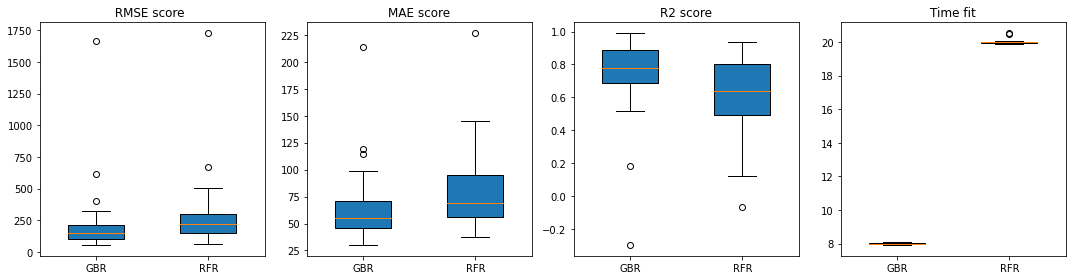

In [ ]:
fig, ax = plt.subplots(1, 4,figsize=(15,4))
ax[0].boxplot([d_gbr['RMSE'],d_rf['RMSE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[0].set_title(" RMSE score  ")
ax[0].set_xticklabels(['GBR', 'RFR']) 
ax[1].boxplot([d_gbr['MAE'],d_rf['MAE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[1].set_title("MAE score")
ax[1].set_xticklabels( ['GBR', 'RFR']) 
ax[2].boxplot([d_gbr['R2'],d_rf['R2']],patch_artist = True,
                 widths =[0.5, 0.5])
ax[2].set_title("R2 score")
ax[2].set_xticklabels(['GBR', 'RFR']) 
ax[3].boxplot([d_gbr['fit_time'],d_rf['fit_time']],patch_artist = True,
                 widths = [0.5, 0.5])
ax[3].set_title("Time fit")
ax[3].set_xticklabels(['GBR', 'RFR']) 
fig.tight_layout()

Les boîtes à moustaches des scores montrent que le Gradient Boosting est meilleur que Random Forest avec une RMSE et MAE la plus basse. Le temps d'entrainement du GBR est aussi moins  élevé que celui de RFR.

## <font id="section_3"> 3. Comparaison des modèles pour l'énergie totale

In [ ]:
import time
start_time = time.time()
dummy_t.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
t=time.time() - start_time
model_accuracy(dummy_t.predict(X_test),y_test['SiteEnergyUse(kBtu)'])

MAE (L1)       6201375.6023
RMSE (L2)      19625997.1003
Mediane-AE      1907418.4489
R2 (CV)          -0.0596


In [ ]:
index=['R2', 'RMSE','MFT_total(s)','MFT(s)']
clc_sc =pd.DataFrame({'Dummy':np.array([-0.0596, -19625997.1003, '-', round(t,3)])},index=index)

### <font id="section_31"> 3.1 Modèles de régression linéaires
#### 3.1.1 Régression linéaire classique

In [ ]:
Sc=[]
param_grid ={'regressor__regressor__fit_intercept':[False,True]}
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_lm_t, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(round(grid_result.best_score_,2))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'MLR':Sc},index=index)],axis=1)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
r2 : -899.7450894959462
Best Params:  {'regressor__regressor__fit_intercept': False}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
neg_root_mean_squared_error : -403466958.435556
Best Params:  {'regressor__regressor__fit_intercept': False}
mean_fit_time: 2.213578462600708


Il semble que le modèle linéaire ne converge pas bien, regardons le modèle Ridge:

#### 3.1.2 Régression Ridge

In [ ]:
Sc=[]
clf_ridge = estimator_pipeline(Ridge(), C_transf)
param_grid = {'regressor__regressor__alpha':np.linspace(0.001,40,41),
              'regressor__regressor__tol':[0.5,0.1,0.01]}
for sc in metric:              
  grid_search = GridSearchCV(estimator = clf_ridge, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'Ridge':Sc},index=index)],axis=1)

Fitting 10 folds for each of 123 candidates, totalling 1230 fits
r2 : 0.49989118323056764
Best Params:  {'regressor__regressor__alpha': 15.000625000000001, 'regressor__regressor__tol': 0.1}
Fitting 10 folds for each of 123 candidates, totalling 1230 fits
neg_root_mean_squared_error : -12649539.006406795
Best Params:  {'regressor__regressor__alpha': 15.000625000000001, 'regressor__regressor__tol': 0.1}
mean_fit_time: 42.43781113624573


#### 3.1.3 Régression Lasso

In [ ]:
Sc=[]
clf_lasso = estimator_pipeline(Lasso(), C_transf)
param_grid = {'regressor__regressor__alpha':np.linspace(0.001,40,81),
              'regressor__regressor__tol':[0.1,0.05,0.001]}
for sc in metric:              
  grid_search = GridSearchCV(estimator = clf_lasso, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'Lasso':Sc},index=index)],axis=1)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
r2 : -0.08511040109670195
Best Params:  {'regressor__regressor__alpha': 0.5009875, 'regressor__regressor__tol': 0.1}
Fitting 10 folds for each of 243 candidates, totalling 2430 fits
neg_root_mean_squared_error : -19860890.263098825
Best Params:  {'regressor__regressor__alpha': 0.5009875, 'regressor__regressor__tol': 0.1}
mean_fit_time: 80.68045377731323


#### 3.1.4 Régression ElasticNet

In [ ]:
Sc=[]
clf_el_net = estimator_pipeline(ElasticNet(), C_transf)
param_grid = {'regressor__regressor__alpha':np.linspace(0.001,20,21),
              'regressor__regressor__l1_ratio':np.linspace(1e-12,1,10),
              'regressor__regressor__tol':[0.1,0.01]}
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_el_net, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'El_Net':Sc},index=index)],axis=1)

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
r2 : -0.06151388727922502
Best Params:  {'regressor__regressor__alpha': 1.0009499999999998, 'regressor__regressor__l1_ratio': 1e-12, 'regressor__regressor__tol': 0.1}
Fitting 10 folds for each of 420 candidates, totalling 4200 fits
neg_root_mean_squared_error : -19689442.758859556
Best Params:  {'regressor__regressor__alpha': 1.0009499999999998, 'regressor__regressor__l1_ratio': 1e-12, 'regressor__regressor__tol': 0.1}
mean_fit_time: 183.77951002120975


### <font id="section_32"> 3.2 Modèle non-linéaires 
 #### 3.2.1 Support vector Regressor

In [ ]:
Sc=[]
clf_svr = estimator_pipeline(SVR(), C_transf)
param_grid = {'regressor__regressor__kernel' : ('rbf', 'sigmoid'),
    'regressor__regressor__gamma' : [ 1e-2, 1e-1], 
              'regressor__regressor__epsilon' : [0.01, 0.05, 0.1], 
              'regressor__regressor__C' : [ 1, 4, 8]} 
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_svr, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'SVR':Sc},index=index)],axis=1)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
r2 : 0.5771641249236052
Best Params:  {'regressor__regressor__C': 1, 'regressor__regressor__epsilon': 0.01, 'regressor__regressor__gamma': 0.1, 'regressor__regressor__kernel': 'rbf'}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
neg_root_mean_squared_error : -12417403.852248903
Best Params:  {'regressor__regressor__C': 1, 'regressor__regressor__epsilon': 0.01, 'regressor__regressor__gamma': 0.1, 'regressor__regressor__kernel': 'rbf'}
mean_fit_time: 278.8830151557922


 #### 3.2.2 Random Forest Regressor

In [ ]:
Sc=[]
param_grid={
     'regressor__regressor__n_estimators' : [10,100,  200],
    'regressor__regressor__min_samples_leaf' : [1, 2,3], 
    'regressor__regressor__max_features': ['auto', 'sqrt']}
clf_rf = estimator_pipeline(RandomForestRegressor(), C_transf)
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_rf, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(grid_result.best_score_)
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'RFR':Sc},index=index)],axis=1)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
r2 : 0.7585580590990226
Best Params:  {'regressor__regressor__max_features': 'auto', 'regressor__regressor__min_samples_leaf': 1, 'regressor__regressor__n_estimators': 10}
Fitting 10 folds for each of 18 candidates, totalling 180 fits
neg_root_mean_squared_error : -9791481.605892615
Best Params:  {'regressor__regressor__max_features': 'auto', 'regressor__regressor__min_samples_leaf': 1, 'regressor__regressor__n_estimators': 10}
mean_fit_time: 787.4948148727419


 #### 3.2.3 Gradient Boosting Regressor

In [ ]:
Sc=[]
clf_gbr = estimator_pipeline(GradientBoostingRegressor(), C_transf)
param_grid = {'regressor__regressor__learning_rate': [0.02,0.03],
                  'regressor__regressor__subsample'    : [0.8, 0.5, 0.1],
                  'regressor__regressor__n_estimators' : [10, 100, 500],
                  'regressor__regressor__max_depth'    : [6,8]
                 }
for sc in metric:
  grid_search = GridSearchCV(estimator = clf_gbr, param_grid=param_grid, cv=10, scoring=sc, verbose=1, n_jobs=-1)
  grid_result = grid_search.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
  Sc.append(round(grid_result.best_score_,3))
  print(sc,':' , grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)
mtf = grid_result.cv_results_['mean_fit_time'].mean()*10*len(grid_result.cv_results_['mean_fit_time'])
Sc.append(round(mtf,3))
Sc.append(round(grid_result.cv_results_['mean_fit_time'].mean(),3))
print('mean_fit_time:', mtf)
clc_sc=pd.concat([clc_sc,pd.DataFrame({'GBR':Sc},index=index)],axis=1)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
r2 : 0.8128696551697485
Best Params:  {'regressor__regressor__learning_rate': 0.03, 'regressor__regressor__max_depth': 6, 'regressor__regressor__n_estimators': 500, 'regressor__regressor__subsample': 0.5}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
neg_root_mean_squared_error : -8234405.704743782
Best Params:  {'regressor__regressor__learning_rate': 0.03, 'regressor__regressor__max_depth': 6, 'regressor__regressor__n_estimators': 500, 'regressor__regressor__subsample': 0.5}
mean_fit_time: 937.7068409919736


### <font id="section_33"> 3.3 Comparaison des résultats

Sur les divers modèles testés, le modèle linéaire Ridge et le SVR retournent des métriques moins bonnes ou moyennes.
Les algorithmes XGBoost et RandomForestRegressor offrent des performances meilleurs que les modèles linéaires 
La qualité des prédictions avec un meilleur score pour XGBoost pour les deux métriques $R_2=0.813$ et RMSE=8234405.705

In [ ]:
# we change the negative RMSE to positive RMSE
clc_sc.loc['RMSE',clc_sc.columns]=clc_sc.loc['RMSE',clc_sc.columns].astype(str).astype('float64')
clc_sc.loc['RMSE',clc_sc.columns]=-clc_sc.loc['RMSE']
clc_sc.T

,R2,RMSE,MFT_total(s),MFT(s)
Dummy,-0.0596,19625997.1003,-,0.021
MLR,-899.75,403466958.44,2.214,0.111
Ridge,0.5,12649539.006,42.438,0.035
Lasso,-0.085,19860890.263,80.68,0.033
El_Net,-0.062,19689442.759,183.78,0.044
SVR,0.577,12417403.852,278.883,0.775
RFR,0.758558,9791481.605893,787.495,4.375
GBR,0.813,8234405.705,937.707,2.605


### <font id="section_34"> 3.4 Cross validation pour RFR et GBR

In [ ]:
scores = cross_validate(clf_rf, X_train, y_train['SiteEnergyUse(kBtu)'], cv=30, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dr = pd.DataFrame(scores)
dr[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dr[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_rf=dr[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2','fit_time']]
d_rf.columns = ['RMSE', 'MAE', 'R2', 'fit_time']
d_rf.describe()

,RMSE,MAE,R2,fit_time
count,3.000000e+01,3.000000e+01,30.000000,30.000000
mean,8.464775e+06,2.495105e+06,0.746399,13.782120
std,7.989503e+06,1.093057e+06,0.188396,0.042366
min,2.257672e+06,9.986569e+05,0.215830,13.693246
25%,4.181558e+06,1.737108e+06,0.680928,13.752750
50%,6.051124e+06,2.321392e+06,0.809348,13.788795
75%,9.018753e+06,2.995345e+06,0.879633,13.807986
max,4.114603e+07,6.225806e+06,0.957033,13.871883


In [ ]:
clf_gbr = estimator_pipeline(GradientBoostingRegressor(learning_rate=0.03,max_depth=8,n_estimators= 500,subsample= 0.8), C_transf)
scores = cross_validate(clf_gbr, X_train, y_train['SiteEnergyUse(kBtu)'], cv=30, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dg = pd.DataFrame(scores)
dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_gbr=dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2','fit_time']]
d_gbr.columns = ['RMSE', 'MAE', 'R2', 'fit_time']
d_gbr.describe()

,RMSE,MAE,R2,fit_time
count,3.000000e+01,3.000000e+01,30.000000,30.000000
mean,7.053847e+06,2.044557e+06,0.818903,7.959435
std,7.761435e+06,1.009062e+06,0.164299,0.049633
min,1.728139e+06,8.822360e+05,0.291194,7.846135
25%,3.329228e+06,1.467380e+06,0.779527,7.932860
50%,4.651950e+06,1.722464e+06,0.870603,7.956073
75%,7.077221e+06,2.391224e+06,0.918952,8.001307
max,3.876258e+07,5.781039e+06,0.994532,8.047136


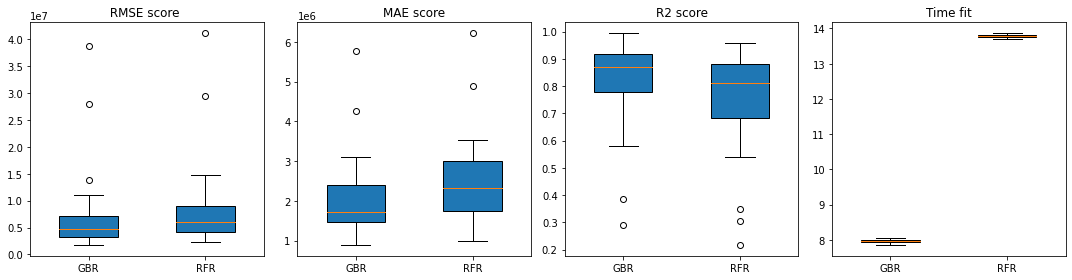

In [ ]:
fig, ax = plt.subplots(1, 4,figsize=(15,4))
ax[0].boxplot([d_gbr['RMSE'],d_rf['RMSE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[0].set_title(" RMSE score  ")
ax[0].set_xticklabels(['GBR', 'RFR']) 
ax[1].boxplot([d_gbr['MAE'],d_rf['MAE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[1].set_title("MAE score")
ax[1].set_xticklabels( ['GBR', 'RFR']) 
ax[2].boxplot([d_gbr['R2'],d_rf['R2']],patch_artist = True,
                 widths =[0.5, 0.5])
ax[2].set_title("R2 score")
ax[2].set_xticklabels(['GBR', 'RFR']) 
ax[3].boxplot([d_gbr['fit_time'],d_rf['fit_time']],patch_artist = True,
                 widths = [0.5, 0.5])
ax[3].set_title("Time fit")
ax[3].set_xticklabels(['GBR', 'RFR']) 
fig.tight_layout()

Les boîtes à moustaches des scores montrent que le Gradient Boosting est meilleur que Random Forest avec une RMSE et MAE la plus basse. Le temps d'entrainement du GBR est aussi moins  élevé que celui de RFR.

## <font id="section_4"> 4 Feature importances 
### <font id="section_41"> 4.1 Emissions du $Co_2$

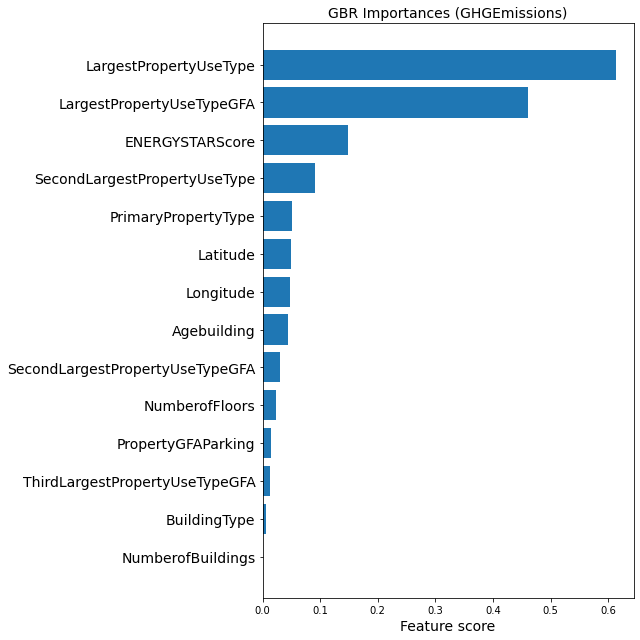

In [ ]:
clf_gbr = estimator_pipeline(GradientBoostingRegressor(learning_rate=0.03,max_depth=8,n_estimators= 500,subsample= 0.8), C_transf)
clf_gbr.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
feature_names = clf_gbr.regressor_.named_steps["ct"].named_transformers_['cat'].get_feature_names_out(input_features=cat_selector(X))
feature_names = np.r_[feature_names, num_selector(X)]
tree_feature_importances = clf_gbr.regressor_.named_steps['regressor'].feature_importances_
sorted_idx = tree_feature_importances.argsort()
df=pd.DataFrame({'feature':feature_names[sorted_idx], 'importance':tree_feature_importances[sorted_idx]})
feat_imp=np.zeros(len(X.columns))
for j in range(0,len(X.columns)):
    feat_imp[j]= (df['importance'][df['feature'].str.contains(X.columns[j])]).sum()

sorted_idx =feat_imp.argsort()
y_ticks = np.arange(0, len(feat_imp))
fig, ax = plt.subplots(figsize=(9,9))
ax.barh(y_ticks, feat_imp[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(X.columns[sorted_idx],fontsize = 14)
ax.set_title("GBR Importances (GHGEmissions)",fontsize = 14)
ax.set_xlabel("Feature score",fontsize = 14)
fig.tight_layout()
plt.show()

### <font id="section_42"> 4.2 Consommation de l'énérgie

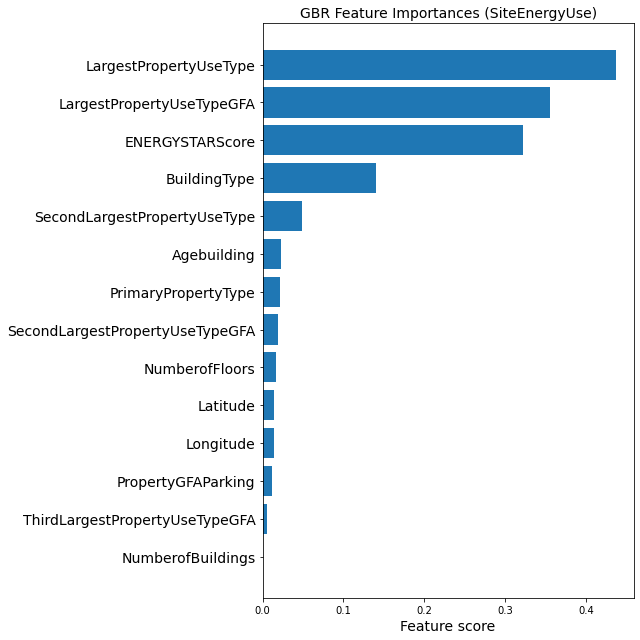

In [ ]:
clf_gbr.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
feature_names = clf_gbr.regressor_.named_steps["ct"].named_transformers_['cat'].get_feature_names_out(input_features=cat_selector(X))
feature_names = np.r_[feature_names, num_selector(X)]
tree_feature_importances = clf_gbr.regressor_.named_steps['regressor'].feature_importances_
sorted_idx = tree_feature_importances.argsort()
df=pd.DataFrame({'feature':feature_names[sorted_idx], 'importance':tree_feature_importances[sorted_idx]})
feat_imp=np.zeros(len(X.columns))
for j in range(0,len(X.columns)):
    feat_imp[j]= (df['importance'][df['feature'].str.contains(X.columns[j])]).sum()

sorted_idx =feat_imp.argsort()
y_ticks = np.arange(0, len(feat_imp))
fig, ax = plt.subplots(figsize=(9,9))
ax.barh(y_ticks, feat_imp[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(X.columns[sorted_idx],fontsize = 14)
ax.set_title("GBR Feature Importances (SiteEnergyUse)",fontsize = 14)
ax.set_xlabel("Feature score",fontsize = 14)
fig.tight_layout()
plt.show()

Le type d'utilisation principale (*LargestPropertyUseType*) et la surface large (*LargestPropertyUseTypeGFA*)
ont un poids plus important dans les décisions de notre modèle pour les deux variables à prédire. En revanche, le nombre de bâtiment a un impact négligeable.
On remarque également que les trois autres type de surface GFA n'ont pas un impact très important sur les prédictions.

## <font id="section_5"> 5 Prédictions des modèles séléctionés
### <font id="section_51"> 5.1 Prédiction de CO$_2$-émissions

Regardons d'abord les résultats des prédictions avec le régresseur simple dummy transformé:

In [ ]:
dummy_t.fit(X_train,y_train['GHGEmissions(MetricTonsCO2e)'])
y_pred = dummy_t.predict(X_test)
model_accuracy(y_pred,y_test['GHGEmissions(MetricTonsCO2e)'])

MAE (L1)       139.7708
RMSE (L2)      570.4369
Mediane-AE      40.0125
R2 (CV)          -0.0362


Les résultas de prédiction par le régresseur GBR:

In [ ]:
import time
start_time = time.time()
clf_gbr.fit(X_train,y_train['GHGEmissions(MetricTonsCO2e)'])
y_pred = clf_gbr.predict(X_test)
print("time_fit : {:.2} s    ".format((time.time() - start_time)))
model_accuracy(y_pred,y_test['GHGEmissions(MetricTonsCO2e)'])

time_fit : 8.4 s    
MAE (L1)       67.0483
RMSE (L2)      245.3126
Mediane-AE      14.1057
R2 (CV)          0.8084


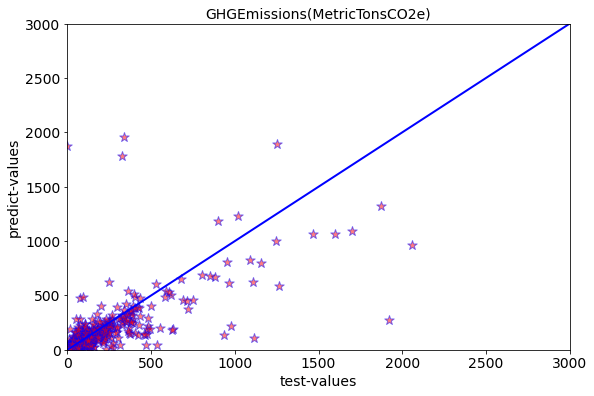

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred, c ='r',lw = 1,
            marker ="*", edgecolor ="b", s=100, alpha=.5)
plt.plot([y_test['GHGEmissions(MetricTonsCO2e)'].min(), y_test['GHGEmissions(MetricTonsCO2e)'].max()],
         [y_test['GHGEmissions(MetricTonsCO2e)'].min(), y_test['GHGEmissions(MetricTonsCO2e)'].max()],c='b',lw=2) 
plt.xlim([0,3000])
plt.ylim([0,3000])
plt.xlabel("test-values",fontsize = 14)
plt.ylabel("predict-values",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('GHGEmissions(MetricTonsCO2e)',fontsize = 14)
plt.show()

Les résultas de prédiction par le régresseur RFR:

In [ ]:
import time
start_time = time.time()
clf_rf.fit(X_train,y_train['GHGEmissions(MetricTonsCO2e)'])
y_pred = clf_rf.predict(X_test)
print("time_fit : {:.2} s    ".format((time.time() - start_time)))
model_accuracy(y_pred,y_test['GHGEmissions(MetricTonsCO2e)'])

time_fit : 1.5e+01 s    
MAE (L1)       74.9644
RMSE (L2)      265.0523
Mediane-AE      16.2185
R2 (CV)          0.7763


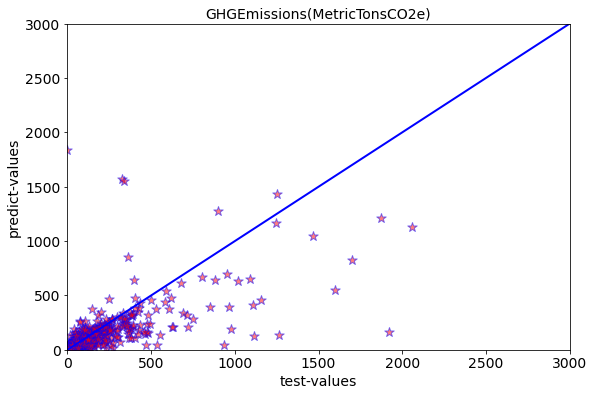

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred, c ='r',lw = 1,
            marker ="*", edgecolor ="b", s=100, alpha=.5)
plt.plot([y_test['GHGEmissions(MetricTonsCO2e)'].min(), y_test['GHGEmissions(MetricTonsCO2e)'].max()],
         [y_test['GHGEmissions(MetricTonsCO2e)'].min(), y_test['GHGEmissions(MetricTonsCO2e)'].max()],c='b',lw=2) 
plt.xlim([0,3000])
plt.ylim([0,3000])
plt.xlabel("test-values",fontsize = 14)
plt.ylabel("predict-values",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('GHGEmissions(MetricTonsCO2e)',fontsize = 14)
plt.show()

### <font id="section_52"> 5.2 Prédiction de la consommation de l'énergie

Les résultas de prédiction par le régresseur simple dummy transformé:

In [ ]:
dummy_t.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
y_pred = dummy_t.predict(X_test)
model_accuracy(y_pred,y_test['SiteEnergyUse(kBtu)'])

MAE (L1)       6201375.6023
RMSE (L2)      19625997.1003
Mediane-AE      1907418.4489
R2 (CV)          -0.0596


Les résultas de prédiction par le régresseur GBR:

In [ ]:
import time
start_time = time.time()
clf_gbr.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
y_pred = clf_gbr.predict(X_test)
print("time_fit : {:.2} s.".format((time.time() - start_time)))
model_accuracy(y_pred,y_test['SiteEnergyUse(kBtu)'])

time_fit : 1.5e+01 s.
MAE (L1)       2165341.3591
RMSE (L2)      10847709.8982
Mediane-AE      409469.0972
R2 (CV)          0.6763


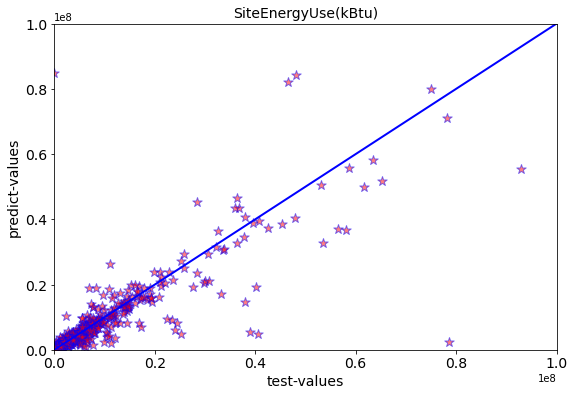

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred, c ='r',lw = 1,
            marker ="*", edgecolor ="b", s=100, alpha=.5)
plt.plot([y_test['SiteEnergyUse(kBtu)'].min(), y_test['SiteEnergyUse(kBtu)'].max()],
         [y_test['SiteEnergyUse(kBtu)'].min(), y_test['SiteEnergyUse(kBtu)'].max()],c='b',lw=2) 
plt.xlim([0,1e8])
plt.ylim([0,1e8])
plt.xlabel("test-values",fontsize = 14)
plt.ylabel("predict-values",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('SiteEnergyUse(kBtu)',fontsize = 14)
plt.show()

Les résultas de prédiction par le régresseur RFR:

In [ ]:
import time
start_time = time.time()
clf_rf.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
y_pred = clf_rf.predict(X_test)
print("time_fit : {:.2} s.".format((time.time() - start_time)))
model_accuracy(y_pred,y_test['SiteEnergyUse(kBtu)'])

time_fit : 1.6e+01 s.
MAE (L1)       2481798.9211
RMSE (L2)      11399597.3670
Mediane-AE      516741.8775
R2 (CV)          0.6425


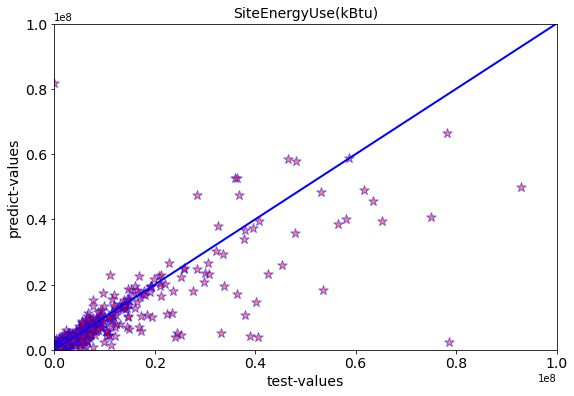

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred, c ='r',lw = 1,
            marker ="*", edgecolor ="b", s=100, alpha=.5)
plt.plot([y_test['SiteEnergyUse(kBtu)'].min(), y_test['SiteEnergyUse(kBtu)'].max()],
         [y_test['SiteEnergyUse(kBtu)'].min(), y_test['SiteEnergyUse(kBtu)'].max()],c='b',lw=2) 
plt.xlim([0,1e8])
plt.ylim([0,1e8])
plt.xlabel("test-values",fontsize = 14)
plt.ylabel("predict-values",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('SiteEnergyUse(kBtu)',fontsize = 14)
plt.show()

Les scores sur les prédictions des deux variables montrent aussi que le gradient Boosting régresseur est meilleur que Random Forest avec une RMSE et MAE la plus basse. Le temps d'entrainement du GBR est aussi moins  élevé que celui de RFR.

## <font id="section_6"> 6. Influence de l'ENERGY STAR Score 

L*'Energy Star Score* est une note entre 1 et 100 dont le but est de désigner l'efficacité énergétique d'un bâtiment
parmi des bâtiments similaires déjà certifiés. Une note de 50 signifie que ce bâtiment se situe dans la médiane, alors qu'une note supérieure à 75 indique qu'il s'agit d'un autre à rendement élevé. 

Afin de quantifier l'influence  de cette variable sur les prédictions pour les deux variables cibles, nous allons comparer les scores du modèle retenu le GBR avec et sans cette variable *Energy Star Score*.

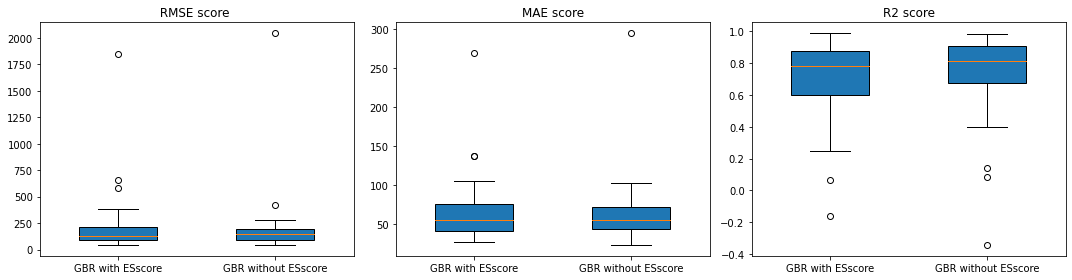

In [ ]:
Xe_train = X_train.drop('ENERGYSTARScore', axis=1)
Xe_test = X_test.drop('ENERGYSTARScore', axis=1)


scores = cross_validate(clf_gbr, X_train, y_train['GHGEmissions(MetricTonsCO2e)'], cv=40, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dg = pd.DataFrame(scores)
dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_gbr=dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2']]
d_gbr.columns = ['RMSE', 'MAE', 'R2']

scores = cross_validate(clf_gbr, Xe_train, y_train['GHGEmissions(MetricTonsCO2e)'], cv=40, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dg = pd.DataFrame(scores)
dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_gbr_star=dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2']]
d_gbr_star.columns = ['RMSE', 'MAE', 'R2']

#plot boxplot of score predictor with and without of the fearure ENERGYSTARScore (ESscore)

fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].boxplot([d_gbr['RMSE'],d_gbr_star['RMSE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[0].set_title(" RMSE score  ")
ax[0].set_title(" RMSE score  ")
ax[0].set_xticklabels(['GBR with ESscore', 'GBR without ESscore']) 
ax[1].boxplot([d_gbr['MAE'],d_gbr_star['MAE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[1].set_title("MAE score")
ax[1].set_xticklabels(['GBR with ESscore', 'GBR without ESscore']) 
ax[2].boxplot([d_gbr['R2'],d_gbr_star['R2']],patch_artist = True,
                 widths =[0.5, 0.5])
ax[2].set_title("R2 score")
ax[2].set_xticklabels(['GBR with ESscore', 'GBR without ESscore'])  
fig.tight_layout()

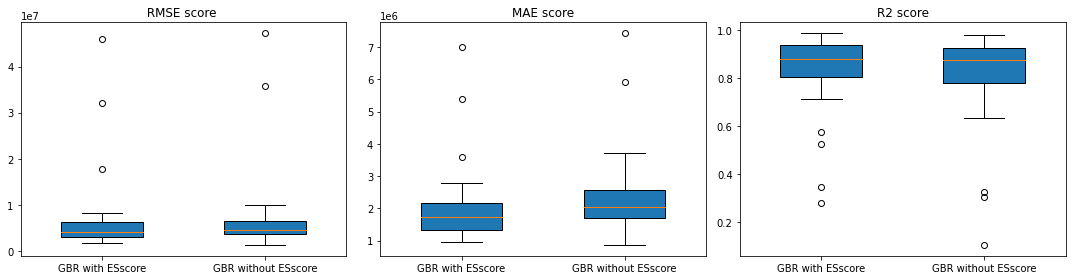

In [ ]:
scores = cross_validate(clf_gbr, X_train, y_train['SiteEnergyUse(kBtu)'], cv=40, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dg = pd.DataFrame(scores)
dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_gbr=dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2']]
d_gbr.columns = ['RMSE', 'MAE', 'R2']

scores = cross_validate(clf_gbr, Xe_train, y_train['SiteEnergyUse(kBtu)'], cv=40, 
                        scoring=['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
dg = pd.DataFrame(scores)
dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']] =-dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']]
d_gbr_star=dg[[ 'test_neg_root_mean_squared_error','test_neg_mean_absolute_error']+['test_r2']]
d_gbr_star.columns = ['RMSE', 'MAE', 'R2']

#plot boxplot of score predictor with and without of the fearure ENERGYSTARScore (ESscore)

fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].boxplot([d_gbr['RMSE'],d_gbr_star['RMSE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[0].set_title(" RMSE score  ")
ax[0].set_title(" RMSE score  ")
ax[0].set_xticklabels(['GBR with ESscore', 'GBR without ESscore']) 
ax[1].boxplot([d_gbr['MAE'],d_gbr_star['MAE']],patch_artist = True,
                widths = [0.5, 0.5])
ax[1].set_title("MAE score")
ax[1].set_xticklabels(['GBR with ESscore', 'GBR without ESscore']) 
ax[2].boxplot([d_gbr['R2'],d_gbr_star['R2']],patch_artist = True,
                 widths =[0.5, 0.5])
ax[2].set_title("R2 score")
ax[2].set_xticklabels(['GBR with ESscore', 'GBR without ESscore'])  
fig.tight_layout()

On remarque que la distribution du RMSE est quasiment semblable avec et sans le label *ENERGY STAR Score*. Une légère amélioration des scores RMSE et $R_2$ pour la cible "*SiteEnergyUse(kBtu)*". Cependant, en plus que cette variable est peu renseignée, cette amélioration n'est pas réellement significative. En prenant compte le coût de cette variable *ENERGY STAR Score*, on conclure que  son influence sur les prédictions du CO2 est négligeable.